In [1]:
from auxiliary import loadData_staticTargetAddrMatch, prepare_data_loaders, create_sequential_inference_loader
from auxiliary import normalize_rss_data, denormalize_predictions, denormalize_rss, plot_rss_vs_position
from auxiliary import plot_sequential_results, run_sequential_inference, apply_normalization
from algorithms import RssPosAlgo_NeuralNet_CNNv1
from algorithms import RssPosAlgo_NeuralNet_supervisedTrainingLoop
from algorithms import RssPosAlgo_NearestNeighbour
from algorithms import RssPosAlgo_NearestNeighbour_Interpolation
from algorithms import RssPosAlgo_NearestNeighbour_GetKmeansDb
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt

In [2]:
target_adresses = ["d8:47:32:eb:6c:38",
                    "50:c7:bf:19:e6:4d",
                    "18:28:61:3d:94:7a"]

In [3]:
for idx, i in enumerate([5,6,7,8]):
    datajsonpath = "../experiments/exp00"+str(i)+"_20250526_sna_kadirerdem/data-tshark/data.json"
    inp_rss_vals1, gt_locations1 = loadData_staticTargetAddrMatch(datajsonpath, second_hold = 5, shuffle=False, 
                                                                target_addresses=target_adresses, snap250ms=False)
    if(idx == 0):
        inp_rss_vals = inp_rss_vals1
        gt_locations = gt_locations1
    else:
        inp_rss_vals = np.concatenate((inp_rss_vals, inp_rss_vals1),axis=0)
        gt_locations = np.concatenate((gt_locations, gt_locations1),axis=0)

In [4]:
norm_params_manual = {
    'rss_mean': np.asarray([-65.0, -65.0, -65.0]),
    'rss_std':  np.asarray([20.0, 20.0, 20.0]),
    'loc_mean': np.asarray([2.0, 2.0]),
    'loc_std':  np.asarray([2.0, 2.0])
}

In [5]:
batch_size       = 64
epochs           = 101
kernel_sizes     = [13, 13, 13, 13]  # Changed from single kernelsize to list
channels         = [32, 32, 32, 2]
total_reduction  = sum(k - 1 for k in kernel_sizes)
min_input_length = total_reduction + 1
window_size      = min_input_length # 50
print("Window size:", window_size)

norm_params = norm_params_manual
inp_rss_vals_norm, gt_locations_norm, _ = apply_normalization(inp_rss_vals, gt_locations, norm_params_manual)

Window size: 49


### Run experiment

In [6]:
# -------------------------------------------------------------
# 1) choose training fractions and experiments to test on
train_fractions = [0.05, 0.10, 0.15, 0.20, 0.25, 0.30, 0.35, 0.40, 0.45, 0.50, 0.55,
                   0.60, 0.65, 0.70, 0.75, 0.80, 0.85, 0.90, 0.95]
experiments     = [5, 6, 7, 8]                           # exp IDs on disk
exp_labels      = ['Exp5', 'Exp6', 'Exp7', 'Exp8']       # for sanity

# containers: rows = fractions, cols = experiments
err_mean_list, err_std_list = [], []

# -------------------------------------------------------------
for frac in train_fractions:
    # ---- train / val split on the *pooled* dataset ----
    train_loader, test_loader, xtr, ytr, xts, yts = prepare_data_loaders(
        inp_rss_vals_norm, gt_locations_norm,
        batch_size=batch_size, window_size=window_size,
        train_test_split=frac, cnn_data=True,
        cnn_kernel_sizes=kernel_sizes
    )
    print(f'\nSubset {frac:.2f}: train {xtr.shape}, test {xts.shape}')
    
    cnn = RssPosAlgo_NeuralNet_CNNv1(channels, kernel_sizes).cuda()
    cnn.cuda()
    cnn.device="cuda"
    opt = optim.Adam(cnn.parameters(), lr=2e-3)
    loss_fn = nn.MSELoss()
    
    cnn = RssPosAlgo_NeuralNet_supervisedTrainingLoop(
            train_loader, test_loader, cnn, loss_fn, opt,
            epochs=epochs, testfreq=100)
    
    # ---- evaluate on each recording separately ----
    mean_err_per_exp, std_err_per_exp = [], []
    for exp_id, tag in zip(experiments, exp_labels):
        print('-'*22, '\nEvaluating', tag)
        data_json = f'../experiments/exp00{exp_id}_20250526_sna_kadirerdem/data-tshark/data.json'
        
        inp_rss_vals, gt_loc = loadData_staticTargetAddrMatch(
            data_json, second_hold=5, shuffle=False,
            target_addresses=target_adresses, snap250ms=False)
        
        inp_norm, loc_norm, _ = apply_normalization(inp_rss_vals,
                                                    gt_loc, norm_params)
        seq_loader, xts_full, yts_full = create_sequential_inference_loader(
            inp_norm, loc_norm, window_size, cnn_data=True,
            cnn_kernel_sizes=kernel_sizes)
        
        res = run_sequential_inference(seq_loader, cnn,
                                       xts_full, yts_full, norm_params,
                                       RssPosAlgo_NearestNeighbour,
                                       RssPosAlgo_NearestNeighbour_Interpolation,
                                       db_kmeans=None)
        
        mean_err_per_exp.append(res['cnn_errors'].mean())
        std_err_per_exp .append(res['cnn_errors'].std())
    
    err_mean_list.append(mean_err_per_exp)
    err_std_list .append(std_err_per_exp)


Subset 0.05: train torch.Size([307, 3]), test torch.Size([5850, 3])
Epoch [1/101] test loss: 0.30255, training loss: -1.00000
Epoch [101/101] test loss: 0.25565, training loss: 0.00039
---------------------- 
Evaluating Exp5
Running sequential inference on 835 windows...
Skipping K-NN inference (db_kmeans is None)

SEQUENTIAL INFERENCE PERFORMANCE SUMMARY
CNN Error: 0.737 ± 0.655 m
K-NN evaluation skipped (db_kmeans was None)
CNN samples: 835
---------------------- 
Evaluating Exp6
Running sequential inference on 1817 windows...
Skipping K-NN inference (db_kmeans is None)

SEQUENTIAL INFERENCE PERFORMANCE SUMMARY
CNN Error: 0.699 ± 0.569 m
K-NN evaluation skipped (db_kmeans was None)
CNN samples: 1817
---------------------- 
Evaluating Exp7
Running sequential inference on 2269 windows...
Skipping K-NN inference (db_kmeans is None)

SEQUENTIAL INFERENCE PERFORMANCE SUMMARY
CNN Error: 0.650 ± 0.535 m
K-NN evaluation skipped (db_kmeans was None)
CNN samples: 2269
---------------------- 


### Plot

In [7]:
err_mean = np.load("pub1_err_mean.npy")
err_std = np.load("pub1_err_stdev.npy")

train_fractions = [0.05, 0.10, 0.15, 0.20, 0.25, 0.30, 0.35, 0.40, 0.45, 0.50, 0.55,
                   0.60, 0.65, 0.70, 0.75, 0.80, 0.85, 0.90, 0.95] 

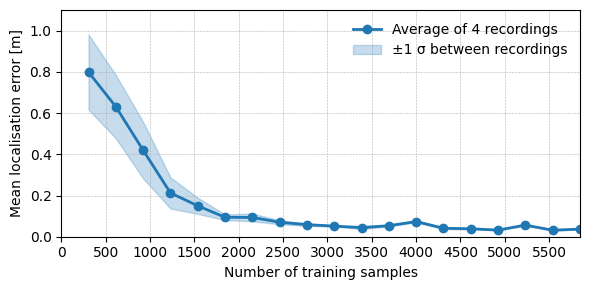

In [10]:
# total number of labelled samples in the pooled set
total_samples = len(inp_rss_vals_norm)          # replace with your variable
train_samples = [int(frac * total_samples) for frac in train_fractions]

# -------------------------------------------------------------
mean_over_runs = err_mean.mean(axis=1)
std_over_runs  = err_mean.std(axis=1)

fig, ax = plt.subplots(figsize=(6, 3))
ax.plot(train_samples, mean_over_runs, marker='o', lw=2, color='tab:blue',
        label='Average of 4 recordings')
ax.fill_between(train_samples,
                mean_over_runs - std_over_runs,
                mean_over_runs + std_over_runs,
                color='tab:blue', alpha=0.25,
                label='±1 σ between recordings')

# --- pretty, regular x-ticks ---------------------------------
max_samp = max(train_samples)
tick_step = 500                                     # choose any spacing
xticks = np.arange(0, max_samp + tick_step, tick_step)

ax.set_xticks(xticks)
ax.set_xticklabels(xticks, rotation=0)              # no tilt needed now
ax.set_xlim(0, max_samp)
# --------------------------------------------------------------

ax.set_xlabel('Number of training samples')
ax.set_ylabel('Mean localization error [m]')
ax.set_ylim(0, 1.1)
ax.grid(True, which='both', ls='--', lw=0.4)
ax.legend(frameon=False)
fig.tight_layout()
plt.savefig("pub1.png")
plt.show()


In [6]:
# -------------------------------------------------------------
# 2) convert to NumPy arrays for later use / plotting
err_mean = np.array(err_mean_list)   # shape (n_frac, n_exp)
err_std  = np.array(err_std_list)

np.save("pub1_err_mean.npy",err_mean)
np.save("pub1_err_stdev.npy",err_std)

NameError: name 'err_mean_list' is not defined